# In what key is "Hey Joe" by Jimi Hendrix?

#### *Disclaimer: I know this is a bit of a controversial subject in the music comunity, so please don't take this post as the only possible truth, but take it more as informational and have fun reading it.*

During my postdoctoral years at [Penn](https://evolution.sas.upenn.edu/), I developed a Julia package with the functions to compute the Spiral Representation and Center of Effect that Elaine Chew developed in her research and presented in her book *Mathematical and Computational Modeling of Tonality*. The goal for this package -besides from make the functions available to more people- was to use the representation to identify and quantify musical features such as *local key* (or immediate tonal center) or *key transitions* and [study their change over time (400 years of western classical music)](https://arxiv.org/abs/2308.03224).  

The main application of the Spiral Representation is to find the tonality (key or tonal center) of a given set of notes. This is achieved by combining different concepts from music, mathematics and physics. 

As an amateur cellist and with a big obsession and curiosity with music, one of my favorite musicians/youtubers happens to be Adam Neely, he made a video a while ago where he makes a very detailed harmony analysis of the song "Hey Joe" by Jimi Hendrix to explain why he thinks the tonality or key of the song is *E*. 

[![](https://img.youtube.com/vi/DVvmALPu5TU/0.jpg)](https://www.youtube.com/watch?v=DVvmALPu5TU)



So I decided to test the variation of Elaine Chew's algorithm that I developed to answer in a more *quantitative* way the question:

<h4 style="text-align: center;">In what key "Hey Joe" is in?</h4>

but first... 

Let's introduce some definitions


# Spiral Representation

The Spiral Representation (or spiral array) is a mathematical model for tonality. A geometric model that represents elements of the tonal system underlying the music with wich we are familiar, since it was constructed with harmony theory of western music.

Inspired by the helican configuration of Longuet-Higgins' harmonic network, also known as the [tonnetz network](https://en.wikipedia.org/wiki/Tonnetz) shown in the next image:

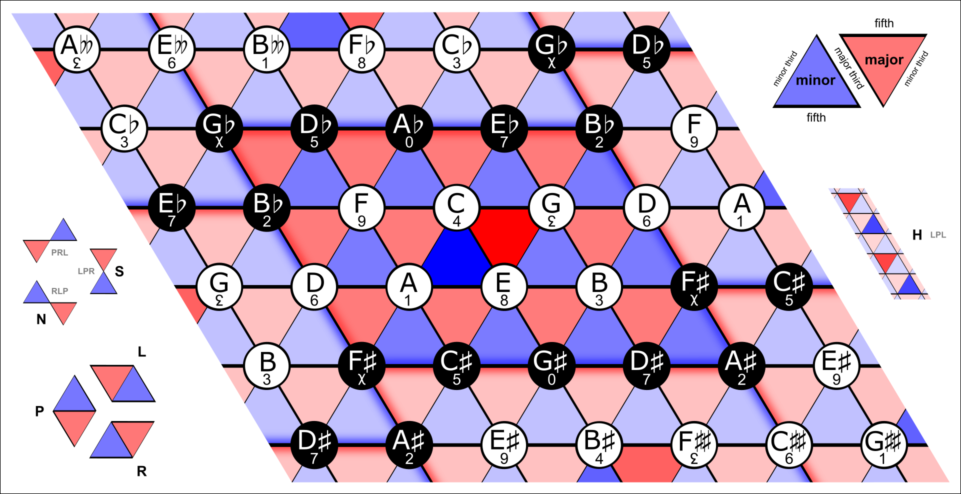

In [9]:
using FileIO
using Images
Images.load("img/Neo-Riemannian_Tonnetz.png")

Pitches and their relationships between them are illustrated in the next image:

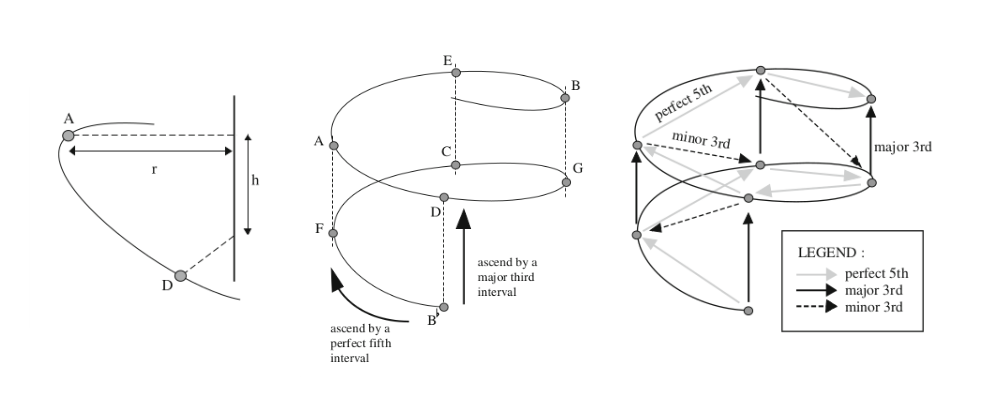

In [12]:
Images.load("img/SpiralArray_Pitches.png")

The tesselation from the Tonnetz model can be illustrated in a better way if we show the planes where the major and minor chords exist:

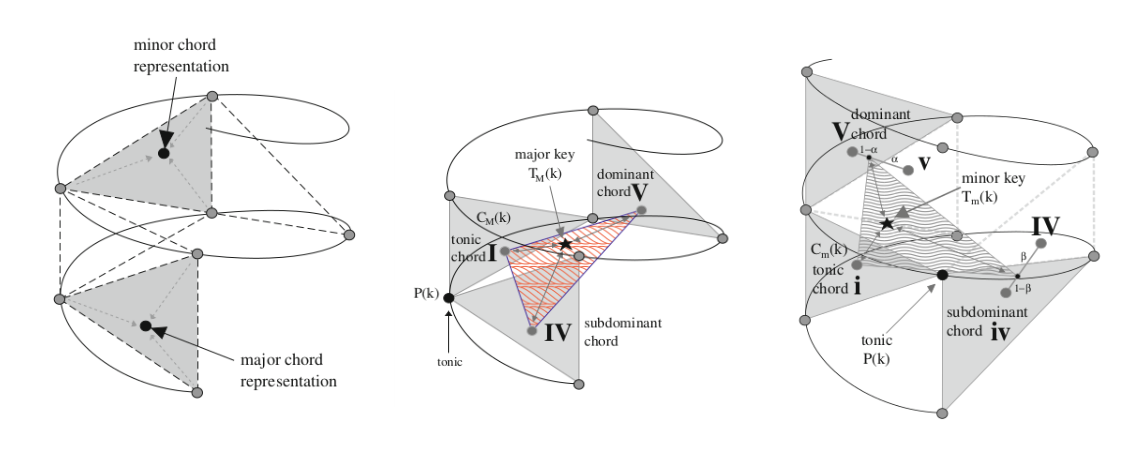

In [13]:
Images.load("img/SpiralArray_Keys.png")

In the spiral array, a pitch $k$ and a pitch $k+n$ are separated by $n$ fifths and are defined as:

$$
    \vec{P}(k) = \begin{bmatrix} x_k \\ y_k \\ z_k \end{bmatrix} = \begin{bmatrix} r sin\frac{k\pi}{2} \\ r cos\frac{k\pi}{2} \\ k h\end{bmatrix} ,
$$




where $r$ and $h$ are fixed: $r=1$ and $h=(2/15)^{1/2}$. And $k$ is a number representing a specific note. The starting note $k_0$ is chosen arbitrary, for simplicity we define $k_0$ as the C note (e.g. with $k_0=$ C, $k+1=$ G, $k+2=$ D and so on).

The major and minor chords are constructed as linear combinations of pitches:

$$
    \vec{C}_M(k) = w_1 \vec{P}(k) + w_2 \vec{P}(k+1) + w_3 \vec{P}(k+4),  
$$

and

$$
    \vec{C}_m(k) = u_1 \vec{P}(k) + u_2 \vec{P}(k+1) + u_3 \vec{P}(k-3),  
$$

where $k+1, k+4$ and $k-3$ are the tonic, major third and minor third respectively in the spiral representation. In the same fashion, the major key representations are defined from the major chords:

$$
    \vec{T}_M(k) = \omega_1 \vec{C}_M(k) + \omega_2 \vec{C}_M(k+1) + \omega_3 \vec{C}_M(k-1),  
$$




where $k+1$ and $k-1$ are the dominant and the subdominant chords, the minor key representations are given by:

\begin{equation}
\begin{aligned}
    \vec{T}_m(k) = {} & \nu_1 \vec{C}_m(k) \\ 
                & + \nu_2 [ \alpha \vec{C}_M(k+1) + (1-\alpha) \vec{C}_m(k+1) ] \\
                & + \nu_3 [ \beta \vec{C}_m(k-1) + (1-\beta) \vec{C}_M(k-1)],
\end{aligned}
\end{equation}

this definition require two extra parameters to weight the different scale patterns that are presented in minor keys (natural, harmonic minor and melodic minor) given by the major and minor dominant and subdominant chords, the parameters $\alpha$ and $\beta$ are set equally: $$\beta = \alpha = 0.75.$$ 

Each weighting vector in the pitch, chord and keys definitions follow $w_1 \geq w_2 \geq w_3 > 0$ and $\sum_i w_i =1$, to consider some notes (or chords) more important than the others (e.g. the tonic in a chord would be more important than the fifth and both more important than the third). For convenience, all these vectors are given equal values: 
$$
\vec{\nu} = \vec{\omega} = \vec{u} = \vec{w} = \{0.536, 0.274, 0.19\} 
$$

making a total of $2+2+3*4 = 16$ parameters for the model. Parameters were chosen from Appendix A (model calibration) of the book [Mathematical and Computational Modeling of Tonality](https://link.springer.com/book/10.1007/978-1-4614-9475-1), where the author uses an heuristic approach explained in great detail.

In Machine Learning language, the Spiral Array can be seen as an embedding for musical notes, chords and keys in $\mathbf{R}^3$ where the distances between them (their *semantic relationships*) are related to the harmonic relationship between them. 

In [15]:
#loading libraries
using CSV
using DataFrames
using Distances
using LinearAlgebra
using Random
using Statistics

## Julia package for the Spiral Representation: MusicSpiralRepresentation.jl

Installation can be done via `repl` with the package manager 

```julia-repl
pkg> add https://github.com/spiralizing/MusicSpiralRepresentation.jl
```

notice that since the package is not registered yet it should be installed using the full github address

In [16]:
#importing package and creating an alias
import MusicSpiralRepresentation
const msr = MusicSpiralRepresentation

MusicSpiralRepresentation

To visualize the representation, we can use the Plots package and write a function to plot the pitches, chords and keys.

Loading plots and utils

In [17]:
using Plots
#defining a function to extract the coordinates in a format that is easier to plot
function get_xyz_loc(fs)
    #concatenate the arrays n x (x,y,z)
    fs_all = hcat(fs...)
    #return three vectors each of them representing one variable (x,y,z)
    fs_x = fs_all[1,:]
    fs_y = fs_all[2,:]
    fs_z = fs_all[3,:]

    return fs_x, fs_y, fs_z
end

get_xyz_loc (generic function with 1 method)

Now we can plot our pitches, chords and keys (p,c,k), but first for better visualization, let's make a line for each of the path that represents each component (p,c,k):

In [18]:
#defining a range for our independent variable
ks = 0:0.001:11
#mapping the range to the spiral representation
#for pitches, chords and keys
fs = map(x -> msr.get_pitch(x), ks)
fsmaj = map(x -> msr.get_Major_chord(x), ks)
fsmin = map(x -> msr.get_minor_chord(x), ks)
fsmak = map(x -> msr.get_Major_key(x), ks)
fsmik = map(x -> msr.get_minor_key(x), ks)
fs_x, fs_y, fs_z = get_xyz_loc(fs)
line_maj = get_xyz_loc(fsmaj)
line_min = get_xyz_loc(fsmin)
line_mak = get_xyz_loc(fsmak)
line_mik = get_xyz_loc(fsmik)

([0.32374800000000004, 0.32418481586179904, 0.324620831829791, 0.32505604682815004, 0.32549045978302643, 0.3259240696225493, 0.32635687527682966, 0.32678887567796244, 0.32722006976002954, 0.32765045645910246  …  -0.28288891308706543, -0.28238625372384585, -0.28188289760061624, -0.2813788459593592, -0.2808741000437696, -0.28036866109925906, -0.2798625303729479, -0.2793557091136646, -0.27884819857193766, -0.27834000000000025], [0.2783400000000001, 0.2778311146517819, 0.27732154378290674, 0.2768112886506898, 0.2763003505141355, 0.27578873063393244, 0.27527643027245163, 0.27476345069374375, 0.2742497931635345, 0.27373545894922324  …  0.31978084050864974, 0.32022480667776526, 0.320667982724001, 0.3211103675538669, 0.32155196007582076, 0.3219927592002795, 0.3224327638396113, 0.3228719729081514, 0.3233103853221941, 0.3237479999999991], [0.04545732078921208, 0.04582246916088217, 0.046187617532552336, 0.04655276590422244, 0.046917914275892536, 0.0472830626475626, 0.04764821101923275, 0.04801335

Pitches, chords and keys are already built-in the package with the parameters  

In [19]:
p_pitches = get_xyz_loc(msr.pitches[1:12])
maj_chords = get_xyz_loc(msr.major_chords[1:12])
min_chords = get_xyz_loc(msr.minor_chords[1:12])
maj_keys = get_xyz_loc(msr.major_keys[1:12])
min_keys = get_xyz_loc(msr.minor_keys[1:12])

([0.32374800000000004, 0.2783400000000001, -0.3237480000000001, -0.27834000000000014, 0.32374800000000004, 0.27834000000000014, -0.3237479999999999, -0.27834000000000014, 0.3237479999999999, 0.27834000000000025, -0.3237479999999998, -0.27834000000000025], [0.2783400000000001, -0.32374800000000004, -0.2783400000000001, 0.32374800000000004, 0.27834000000000014, -0.32374800000000004, -0.2783400000000002, 0.32374800000000004, 0.27834000000000014, -0.323748, -0.27834000000000086, 0.3237479999999991], [0.04545732078921208, 0.4106056924593229, 0.7757540641294336, 1.1409024357995443, 1.5060508074696553, 1.871199179139766, 2.2363475508098767, 2.6014959224799874, 2.966644294150098, 3.3317926658202093, 3.69694103749032, 4.062089409160429])

And now we can plot the pitches, chords and keys in the **Spiral Representation**

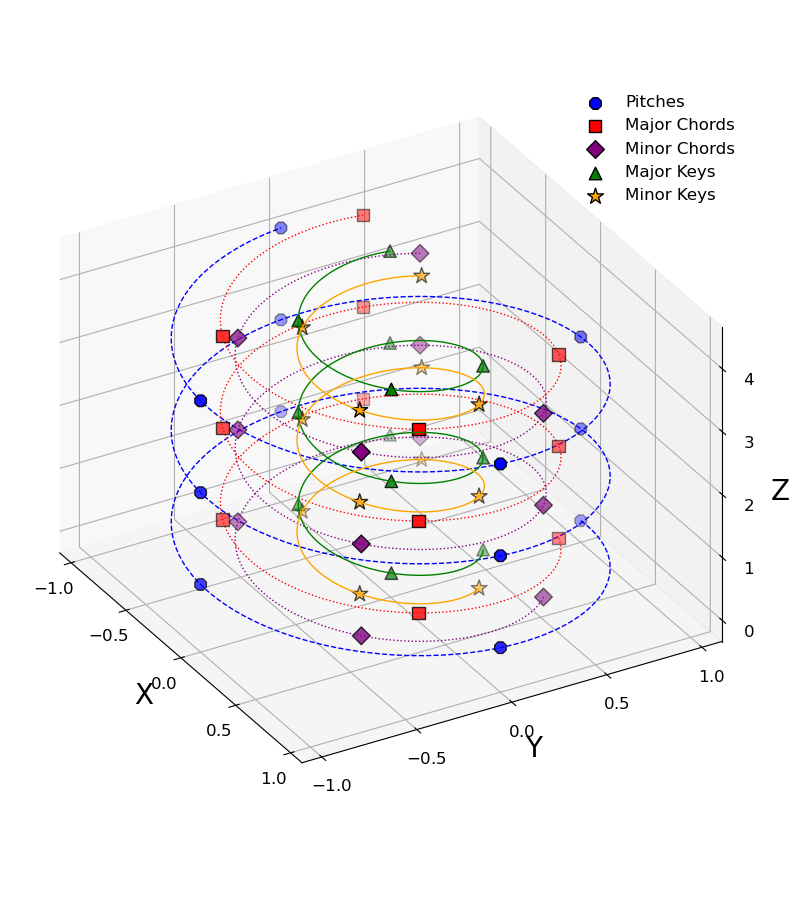

In [28]:
pyplot(guidefont=20, titlefont=30, xtickfont=12, ytickfont=12, ztickfont=12, legendfont=12)
plot(fs_x, fs_y, fs_z, label="", linewdith=20, color=:blue, background_color=RGBA(1, 1, 1, 0),
    camera=(60, 30), linestyle=:dash, zmirror=true, xlabel="X", ylabel="Y", zlabel="Z")
scatter!(p_pitches[1], p_pitches[2], p_pitches[3], size=(800, 900), m=:o, color=:blue, ms=9, label="Pitches")
plot!(line_maj[1], line_maj[2], line_maj[3], label="", linewdith=20, color=:red, linestyle=:dot)
scatter!(maj_chords[1], maj_chords[2], maj_chords[3], m=:square, color=:red, ms=9, label="Major Chords")
plot!(line_min[1], line_min[2], line_min[3], label="", linewdith=20, color=:purple, linestyle=:dot)
scatter!(min_chords[1], min_chords[2], min_chords[3], m=:diamond, color=:purple, ms=9, label="Minor Chords")
plot!(line_mak[1], line_mak[2], line_mak[3], label="", linewdith=20, color=:green)
scatter!(maj_keys[1], maj_keys[2], maj_keys[3], m=:utriangle, color=:green, ms=9, label="Major Keys")
plot!(line_mik[1], line_mik[2], line_mik[3], label="", linewdith=20, color=:orange)
scatter!(min_keys[1], min_keys[2], min_keys[3], m=:star, color=:orange, ms=12, label="Minor Keys")

# The Center of Effect algorithm

The center of effect is an algorithm developed to find the most likely tonality (key) for a given set of notes in the spiral array, $P = \{\vec{p}_1, \vec{p}_2,...,\vec{p}_N\}$. This algorithm uses the concept of *center of mass* to represent the notes with an **effective** tonal center in the form of a linear combination of the positions of the notes in the spiral array:

$$
    \vec{C}_e = \sum_{i=1}^N \omega_i \vec{p_i},
$$

where the weights $\omega_i$ represent the *importance* of the note and to mantain the values within the same boundaries the weights are normalized $\sum_i w_i = 1$. 

Weights can be built however we want, but one of the most natural musical features we can use for the weights is the **duration** of each note, under de assumption that notes that last longer are more relevant for the tonal center. 

In summary, the Center of Effect (CoE) key finding algorithm uses the vector $\vec{C}_e$ for the set of notes, and defines the most likely key as:

$$
    \argmin_{T \in \bm{T}} || \vec{C}_e - \vec{T} ||,
$$

which corresponds to the key $T$ for which the euclidean distance to the measure is minimum. Here $\bm{T}$ is the set of possible major and minor keys: $\bm{T} = \{ \bm{T}_M(k) \forall k\} \cup \{\bm{T}_m(k) \forall k \}$.

To exemplify how it works, let's do one of the simplest tests: 
<p style="text-align: center;">What key are the C major and c minor chords?</p>


The ```MusicSpiralRepresentation.jl``` package uses the same [numerical notation](https://www.inspiredacoustics.com/en/MIDI_note_numbers_and_center_frequencies) that [MIDI](https://en.wikipedia.org/wiki/MIDI) uses.

In [36]:
# array of notes in MIDI notation
c_major = [60, 64, 67] # C major chord
c_minor = [60, 63, 67] # c minor chord

3-element Vector{Int64}:
 60
 63
 67

and then, we can compute the center of effect with the function ```get_center_effect()```, this function can accept a sigle array of numbers representing the notes in MIDI notation or two arrays of numbers representing the notes in MIDI notation and their respective durations. Duration units are irrelevant since the algorithm involves a normalization.

We can see that each center of effect is different:

In [31]:
#first C major
msr.get_center_effect(c_major)

3-element Vector{Float64}:
 0.33333333333333226
 0.6666666666666665
 9.372141539532842

In [32]:
msr.get_center_effect(c_minor)

3-element Vector{Float64}:
 0.6666666666666661
 0.3333333333333331
 8.520128672302583

To know in what key the two sets of notes are, we need to compute the distances from the center of effect to each of the different keys in the Spiral Representation. 

We can do this by calling the function ```get_distance_to_keys(center_of_effect)```, the function takes as argument the vector (x,y,z) for the center of effect and returns a Matrix{Any} with the keys ordered by their respective distances.

So we know what we expect if we call this function for the center of effect of our variable ```c_major```:

In [34]:
msr.get_distance_to_keys(msr.get_center_effect(c_major))[1:5,:]

5×2 Matrix{Any}:
 "C"  0.3824
 "c"  0.6841
 "a"  0.8804
 "G"  0.8905
 "e"  0.9779

and for ```c_minor```:

In [35]:
msr.get_distance_to_keys(msr.get_center_effect(c_minor))[1:5,:]

5×2 Matrix{Any}:
 "c"   0.4517
 "Eb"  0.7617
 "C"   0.7977
 "Ab"  0.9306
 "f"   0.9481

I made this computation to be the same for notes in any octave: only using a 12-note musical notation, so in principle if we do a translation by a multiple of octaves (12 semi-tones) the center of mass will be in the same position regardless of the octave of its notes.

We can see this if we move some of the notes in the C major chord: 

In [52]:
# doing a  -12 move in x and a +2*12 move in y 
cmajor_2 = [60-12, 64, 67+24]
#computing the distance to keys
msr.get_distance_to_keys(msr.get_center_effect(cmajor_2))[1:5, :]

5×2 Matrix{Any}:
 "C"  0.2618
 "G"  0.4911
 "c"  0.5988
 "g"  0.6182
 "a"  0.7324

and we obtain the same values as if we compute the distance to keys from the original center (no translation).

Now let's add some weights to those notes, since weights don't really need to be normalized as input we can use any numbers:

In [86]:
w_1 = [3,2,1]
w_2 = [1,10,1]
keys_w1 = msr.get_distance_to_keys(msr.get_center_effect(c_major, w_1))[1:5, :]
keys_w2 = msr.get_distance_to_keys(msr.get_center_effect(c_major, w_2))[1:5, :]

print("List of closest keys for $c_major with $w_1 weights: \n")
print("$keys_w1 \n \n")
print("List of closest keys for $c_major with $w_2 weights: \n")
print("$keys_w2 \n")

List of closest keys for [60, 64, 67] with [3, 2, 1] weights: 
Any["C" 0.4893; "c" 0.7648; "a" 0.8998; "F" 0.9642; "G" 1.0839] 
 
List of closest keys for [60, 64, 67] with [1, 10, 1] weights: 
Any["a" 0.7027; "e" 0.7294; "E" 0.8394; "A" 0.8775; "C" 1.0115] 


Interestingly, the set of weights ```w_2``` adds enough emphasis on the *E* pitch to make the resultant $\vec{C}_{w_1}$ closer to *A* minor than *C* major. This result does make sense because the note *E* is a perfect fifth away from *A* and makes it the dominant key for *A* major and minor. This is true in this case when we are giving more importance to the second note by a factor of 10.

Now let's try the algorithm with real examples, I have made some annotations in the music score excerpt of the sonata no. 16 (not 15, I am not sure why the edition of this piece on IMSLP had this number) dividing the first line into measures and I wrote down to what my music theory training tells me the key for that measure is. It is difficult to assing a single tonal key for each measure so I wrote down if there was a second key that could be considered for the measure.

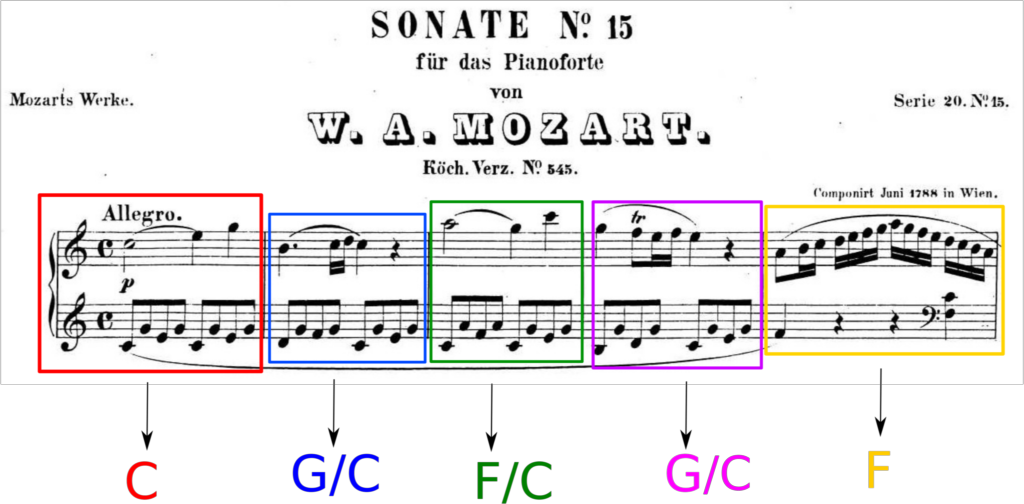

In [63]:
Images.load("img/MozartSonata.png")

Instead of input the whole piece note by note, we can use one of the formats supported by the package ```MusicSpiralRepresentation.jl```. The package has functions to process files of two different formats: [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) and [MusicXML](https://en.wikipedia.org/wiki/MusicXML). The CSV files can be obtained by converting MIDI files into CSV files with the software [midicsv](https://www.fourmilab.ch/webtools/midicsv/) available for free online.

For this particular piece I was lucky enough to find a Music XML file in [MuseScore](https://musescore.com/sheetmusic?text=mozart%20piano%2016), a music notation software that uses the MusicXML as one of their main formats in their music collection.

To load and process the MusicXML file the package uses functions from Music21 a *python toolkit for computer-aided musicology*, one of the advantages of Julia is that it has support to import functions from other programming languages like Python. To be able to do this we use the [PyCall](https://github.com/JuliaPy/PyCall.jl) package that allows us to call Python functions from our Python installation, this means we need to have the module Music21 installed in the environment we are using with Julia.

*Note: I still need to work on a solution to include MIDI.jl in the package for MIDI files manipulation.*

In [64]:
# Importing PyCall and loading the module music21 as m21.
using PyCall
m21 = pyimport("music21")

PyObject <module 'music21' from '/home/alfredo/.local/lib/python3.10/site-packages/music21/__init__.py'>

And now we can load the music score obtained from MuseScore, using the parser/converter that is included in music21: 

In [65]:
mozart_16 = m21.converter.parse("files/Mozart_16.mxl")

PyObject <music21.stream.Score 0x7fb1f3fbf370>

The function ```m21.converter.parse()``` returns an object that contains all the information from the music score. To represent the music score in a more convenient way we can use the function ```get_xml_df()``` that takes the m21 object as input and returns a Data Frame with the information we need to compute the most likely keys on each measure:

| `measure`| `Time signature`|`start` | `end` | `duration` | `pitch`| 

In [66]:
df_mozart16 = msr.get_xml_df(mozart_16)

Row,Measure,TimeSignature,StartQuarter,EndQuarter,Duration,Pitch
,Int64,Any,Any,Any,Any,Int64
1,1,4/4,0.0,2.0,2.0,72
2,1,4/4,2.0,3.0,1.0,76
3,1,4/4,3.0,4.0,1.0,79
4,1,4/4,0.0,0.5,0.5,60
5,1,4/4,0.5,1.0,0.5,67
6,1,4/4,1.0,1.5,0.5,64
7,1,4/4,1.5,2.0,0.5,67
8,1,4/4,2.0,2.5,0.5,60
9,1,4/4,2.5,3.0,0.5,67


And we can divide the piece by measure:

In [68]:
mozart16_measures = groupby(df_mozart16, :Measure);
#showing first measure
mozart16_measures[1]

Row,Measure,TimeSignature,StartQuarter,EndQuarter,Duration,Pitch
,Int64,Any,Any,Any,Any,Int64
1,1,4/4,0.0,2.0,2.0,72
2,1,4/4,2.0,3.0,1.0,76
3,1,4/4,3.0,4.0,1.0,79
4,1,4/4,0.0,0.5,0.5,60
5,1,4/4,0.5,1.0,0.5,67
6,1,4/4,1.0,1.5,0.5,64
7,1,4/4,1.5,2.0,0.5,67
8,1,4/4,2.0,2.5,0.5,60
9,1,4/4,2.5,3.0,0.5,67


The function `get_center_effect()` can take a Matrix with this information as argument, so we just need to convert it to Matrix first and call the function, doing that with the first measure we get

In [77]:
msr.get_distance_to_keys(msr.get_center_effect(Matrix(mozart16_measures[1])))[1:3, :]

3×2 Matrix{Any}:
 "C"  0.3221
 "c"  0.5756
 "G"  0.876

Result that agrees with the annotation for the first measure of the piece, we do this for all the other measures and inspect the first five to check which one is the most likely key for each:

In [76]:
#defining a function to extract only the three closest keys 
function get_closest_keys(measure)
    return msr.get_distance_to_keys(msr.get_center_effect(Matrix(measure)))[1:3,:]
end

#computing the closest keys for each of the measures
closest_keys = [get_closest_keys(mozart16_measures[i]) for i =1:length(mozart16_measures)];

We inspect the results for the first five measures, remembering the annotations: "C", "G/C", "F/C", "G/C","F". 


In [85]:
#printing the first 5 measures 
for i = 1:5
    print("The closest keys for measure $i are \n")
    print("$(closest_keys[i]) \n \n")
end

The closest keys for measure 1 are 
Any["C" 0.3221; "c" 0.5756; "G" 0.876] 
 
The closest keys for measure 2 are 
Any["C" 0.3622; "G" 0.4436; "g" 0.6086] 
 
The closest keys for measure 3 are 
Any["C" 0.4307; "F" 0.5666; "a" 0.5777] 
 
The closest keys for measure 4 are 
Any["C" 0.2967; "G" 0.4668; "c" 0.5786] 
 
The closest keys for measure 5 are 
Any["F" 0.2962; "C" 0.5891; "d" 0.6592] 
 


which is in agreement with the annotations. The algorithm doesn't only guess the closest key, it lists all the keys with their respective distances to the center of effect, this information can be useful to know what other keys can be considered and how close those keys are. Inspecting the second most likely keys from the algorithm we can confirm that they also agree with the annotations (for measures 2,3 and 4).

# In what key is "Hey Joe" by Jimi Hendrix? 


The approach we are going to take (there can be other alternatives) to decide in what key the song "Hey Joe" is in, is to call the closest key for each measure and then define the global key of the song as the most repeated one, in other words, the key where the center of effect spent the largest amount of time (where time units are defined as measures) in the song.

In [100]:
using DelimitedFiles

#loading the csv file with delimitedfiles
heyjoe_csv = readdlm("files/HeyJoe.csv",',')

#
df_heyjoe = msr.get_csv_df(heyjoe_csv)

#grouping by measure
heyjoe_measures = groupby(df_heyjoe, :Measure);

In [95]:
#writing a function that retunrs only the most likely key
function get_closest_key(measure)
    #returns only the first key 1,1
    return msr.get_distance_to_keys(msr.get_center_effect(Matrix(measure)))[1,1]
end

#computing the closest key for each of the measures
heyjoe_keys = [get_closest_key(heyjoe_measures[i]) for i = 1:length(heyjoe_measures)];

And now we can get the most repeated key. To do this we can use the function ```get_rank_freq()``` that receives a sequence (array) and counts how many elements it has for each of the set of unique elements of the sequence, returning an ordered list where the first element is the most repeated one (first rank - highest frequency). 

In [97]:
msr.get_rank_freq(heyjoe_keys)

7×2 Matrix{Any}:
 "E"     21
 "D"     18
 "e"     16
 "C"     13
 "G"      5
 "B/Cb"   1
 "b"      1

With this result the only thing that is left is to cite Adam Neely...

<h1 style="text-align: center;">It's in E.</h1>
